In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import matplotlib.pyplot as plt

2023-11-28 21:57:06.702362: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 21:57:07.406951: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 21:57:08.820504: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-11-28 21:57:08.820777: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinf

In [2]:
# Загрузка данных MNIST
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = (train_images.astype(np.float32) - 127.5) / 127.5
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)

In [4]:
# Гиперпараметры
latent_dim = 100
generator_input_shape = (latent_dim,)
discriminator_input_shape = (28, 28, 1)

In [5]:
# Генератор
def build_generator():
    model = models.Sequential()
    model.add(layers.Dense(7 * 7 * 128, input_shape=generator_input_shape))
    model.add(layers.Reshape((7, 7, 128)))
    model.add(layers.BatchNormalization())
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(1, (5, 5), padding='same', activation='tanh'))
    return model

In [6]:
# Дискриминатор
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=discriminator_input_shape))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [7]:
# Создание и компиляция моделей
generator = build_generator()
discriminator = build_discriminator()

discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])
discriminator.trainable = False

gan_input = tf.keras.Input(shape=generator_input_shape)
x = generator(gan_input)
gan_output = discriminator(x)

gan = models.Model(gan_input, gan_output)
gan.compile(optimizer=tf.keras.optimizers.Adam(0.0002, 0.5), loss='binary_crossentropy')

2023-11-28 21:57:36.382531: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 21:57:37.652777: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6170 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050, pci bus id: 0000:03:00.0, compute capability: 8.6


In [8]:
# Обучение GAN
def train_GAN(epochs, batch_size):
    batch_count = train_images.shape[0] // batch_size

    for epoch in range(epochs):
        for _ in range(batch_count):
            noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
            generated_images = generator.predict(noise)

            image_batch = train_images[np.random.randint(0, train_images.shape[0], batch_size)]

            X = np.concatenate([image_batch, generated_images])
            y_dis = np.zeros(2 * batch_size)
            y_dis[:batch_size] = 1

            discriminator_loss = discriminator.train_on_batch(X, y_dis)

            noise = np.random.normal(0, 1, size=(batch_size, latent_dim))
            y_gen = np.ones(batch_size)

            generator_loss = gan.train_on_batch(noise, y_gen)

        print(f"Epoch {epoch + 1}, D Loss: {discriminator_loss[0]}, G Loss: {generator_loss}")

        if (epoch + 1) % 10 == 0:
            plot_generated_images(generator, epoch + 1, latent_dim)

In [19]:
# Вспомогательная функция для отображения сгенерированных изображений
def plot_generated_images(generator, epoch, examples=10, dim=(1, 10), figsize=(10, 1)):
    noise = np.random.normal(0, 1, size=(examples, latent_dim))
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(10):
        plt.subplot(dim[0], dim[1], i + 1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(f'gan_generated_image_epoch_{epoch}.png')

2023-11-28 21:58:00.936485: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-11-28 21:58:01.215897: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400


4/4 [==============================] - 0s 2ms/step
Epoch 1, D Loss: 0.5870490074157715, G Loss: 0.8968984484672546
4/4 [==============================] - 0s 2ms/step
Epoch 2, D Loss: 0.6441842317581177, G Loss: 0.7332647442817688
4/4 [==============================] - 0s 2ms/step
Epoch 3, D Loss: 0.6553922891616821, G Loss: 0.8252195119857788
4/4 [==============================] - 0s 2ms/step
Epoch 4, D Loss: 0.6555165648460388, G Loss: 0.7418686747550964
4/4 [==============================] - 0s 2ms/step
Epoch 5, D Loss: 0.6369408369064331, G Loss: 0.716626763343811
4/4 [==============================] - 0s 2ms/step
Epoch 6, D Loss: 0.6765701770782471, G Loss: 0.8033419251441956
4/4 [==============================] - 0s 2ms/step
Epoch 7, D Loss: 0.5998896360397339, G Loss: 0.9099293947219849
4/4 [==============================] - 0s 2ms/step
Epoch 8, D Loss: 0.6199343800544739, G Loss: 0.9293490052223206
4/4 [==============================] - 0s 2ms/step
Epoch 9, D Loss: 0.64625608921

ValueError: num must be an integer with 1 <= num <= 10, not 11

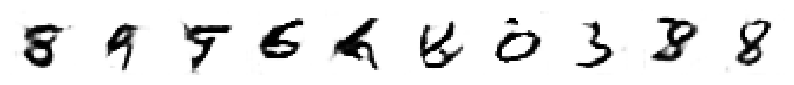

In [10]:
# Обучение GAN
train_GAN(epochs=10, batch_size=128)

In [11]:
# Сохранение генератора
generator.save('generator_model.h5')

# Сохранение дискриминатора
discriminator.save('discriminator_model.h5')

In [12]:
gan.save('gan_model.h5')

In [ ]:
# Загрузка моделей
loaded_generator = tf.keras.models.load_model('generator_model.h5')
loaded_discriminator = tf.keras.models.load_model('discriminator_model.h5')
loaded_gan = tf.keras.models.load_model('gan_model.h5')

4/4 [==============================] - 0s 3ms/step


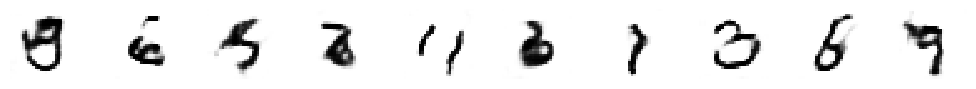

In [24]:
plot_generated_images(generator, '', latent_dim)